# Planificador Lineal

Características:
1. Modelo de Difusión
    * Scheduler Lineal
    * U-NET para la red neuronal
    * El modelo predecirá la imagen limpia directamente, no el ruido.

    * __Modificaremos la red con respecto al original, para mejorar los resultados.__
    
2. Dataset: MNIST
    * 256 de tamaño de lote
3. Optimizador: AdamW
4. Función de Coste: Error Cuadrático Medio (MSE)

In [1]:
import torch
import diffusers
import matplotlib.pyplot as plt
from torchvision import transforms, datasets

# from PIL import Image
# import numpy as np

## Código auxiliar para mostrar imágenes

In [2]:
def show_images(images_tensor:torch.tensor):
    n_dims = images_tensor.dim()
    
    if n_dims in (2,3):
        x_cat = images_tensor

    elif n_dims == 4:
        x_list = [img for img in images_tensor]
        x_cat = torch.cat(x_list,dim=2)
    
    else:
        raise SyntaxError("The dimensions of images_tensor must be between 2 and 4")

    if n_dims != 2:
        if x_cat.shape[0] == 1:
            plt.imshow(x_cat.movedim(0,-1),cmap="gray");
        else:
            plt.imshow(x_cat.movedim(0,-1));
    else:
        plt.imshow(x_cat,cmap="gray");

In [3]:
def show_images_list(images_list:list[torch.Tensor]) -> None:

    images_tensor = torch.stack(images_list)

    # return images_tensor
    # show_images(images_tensor.unsqueeze(1))
    show_images(images_tensor)

## Preparación del Dataset

In [4]:
image_size = 32
preprocess = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
    ]
)

In [5]:
mnist_dataset = datasets.MNIST(
    root="Mnist_dataset",
    download=True,
    train=True,
    transform=preprocess
)

In [6]:
mnist_dataset # Dataset de 60000 imágenes de Números escritos a mano.

Dataset MNIST
    Number of datapoints: 60000
    Root location: Mnist_dataset
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

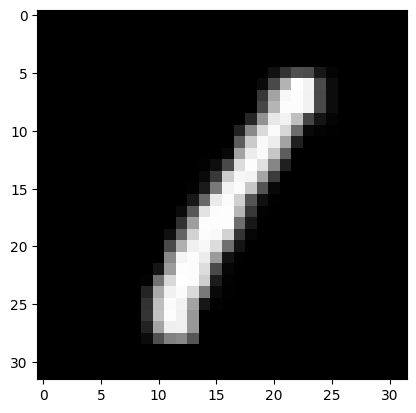

In [7]:
show_images(mnist_dataset[3][0])

In [8]:
train,val,_ = torch.utils.data.random_split(mnist_dataset,(0.5,0.1,0.4))


batch_size = 256
train_loader = torch.utils.data.DataLoader(
    dataset=train,
    shuffle=True,
    batch_size=batch_size
)

val_loader = torch.utils.data.DataLoader(
    dataset=val,
    shuffle=True,
    batch_size=batch_size
)

In [9]:
print(f"Tamaño de dataset para entrenamiento: {len(train)}")
print(f"Tamaño de dataset para validación: {len(val)}")
# Usaremos solamente 30000 de las imágenes.


Tamaño de dataset para entrenamiento: 30000
Tamaño de dataset para validación: 6000


torch.Size([256, 1, 32, 32])


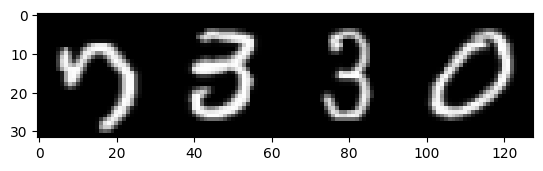

In [10]:
batch = next(iter(train_loader))[0]

print(batch.shape)
show_images(batch[::80])

## Añadiendo Ruido
Usaremos un planificador lineal y compararemos los resultados con los obtenidos originalmente.

In [13]:
class LinealScheduler:
    def __init__(self, num_train_timesteps:int = 1000):
        self.num_train_timesteps = num_train_timesteps
        self.timesteps = torch.linspace(self.num_train_timesteps-1 ,0,self.num_train_timesteps, dtype=int).cuda()

    def add_noise(self, x, noise, timesteps):
        amount = timesteps/ self.num_train_timesteps
        return self.__corrupt(x, noise, amount)
    
    @staticmethod
    def __corrupt(x,noise,amount):
        
        amount = amount.view(-1,1,1,1) # Para asegurar que se pueda realizar la multiplicación.

        # return(
        #     x * (1-amount) + (noise * amount)   # Restamos "amount" a la imagen para que
        #                                         # no se modifiquen las propiedades estadísticas de la imagen
        # )
        return(x.lerp(noise, amount))   # Equivalente, pero Más rápido que manual.
    
    def step(self,noise,t,x_0_pred):
        prev_t = t-1
        a_t_1 = (prev_t/self.num_train_timesteps)

        return (
            self.__corrupt(x_0_pred,noise,a_t_1)
        )
    def set_timesteps(self,new_timesteps):
        self.num_train_timesteps = new_timesteps
        self.timesteps = torch.linspace(self.num_train_timesteps-1 ,0,self.num_train_timesteps, dtype=int).cuda()

El modelo será entrenado para la predicción de la imagen limpia directamente, en vez del ruido. Por este motivo,mejorando la estabilidad de los cálculos

amount -> $$a_{t-1} = \frac{t-1}{num\_train\_timesteps}$$

$$x_t = x_0 \cdot (1-a_t) + (noise \cdot a_t)$$

Al conocer $x_0$, podemos calcular el paso anterior re-calculado a según el paso dado

$$x_{t-1} = x_{0\_pred} \cdot (1-a_{t-1}) + (noise \cdot a_{t-1})$$

Este caso es mucho más estable que cuando predecimos el ruido de la imagen

In [14]:
scheduler = LinealScheduler()
scheduler.timesteps


tensor([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986,
        985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972,
        971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958,
        957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944,
        943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930,
        929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916,
        915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902,
        901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888,
        887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874,
        873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860,
        859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846,
        845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832,
        831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 8

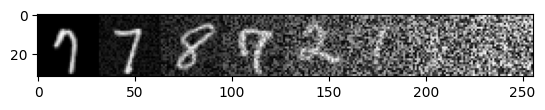

In [15]:
# Create a tensor with 8 evenly spaced values from 0 to 999
timesteps = torch.linspace(0, 999, 8).long()

# We load 8 images from the dataset and
# add increasing amounts of noise to them
batch = next(iter(train_loader))
x = batch[0][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

show_images(noised_x)

In [16]:
noised_x.shape

torch.Size([8, 1, 32, 32])

## U-NET

In [17]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=1,  # 1 channels for grey scale
    sample_size=image_size,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(64, 64, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
        ),
    out_channels=1

).cuda()

# Pass a batch of data through to make sure it works. The dimensions of tensors must be the same
with torch.inference_mode():
    model.eval()
    out = model(noised_x.cuda(), timestep=timesteps.cuda()).sample
    model.train()

print(noised_x.shape)
print(out.shape)

torch.Size([8, 1, 32, 32])
torch.Size([8, 1, 32, 32])


# Entrenamiento

In [18]:
n_epochs = 8
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
loss_fn = torch.nn.functional.mse_loss
losses = []

In [19]:
# Bucle de entrenamiento
from torch import nn
def train_loop(loader:torch.utils.data.DataLoader, model : nn.Module, scheduler: LinealScheduler, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    # train_size = len(loader.dataset)

    model.train()   #Preparo el modelo para el entrenamiento

    train_losses = 0
    losses_list = []

    # losses_list = []

    for nlote,x in enumerate(loader):
        x = x[0].cuda()

        ## Noise
        # Make noise
        noise = torch.randn_like(x).cuda()

        # Create random timesteps to the training
        timesteps = torch.randint(
            0,
            scheduler.num_train_timesteps,
            (x.shape[0],)
        ).long().cuda()

        # Add Noise to images
        noisy_x = scheduler.add_noise(x,noise,timesteps)

        ## Forward Pass
        image_pred = model(noisy_x, timesteps, return_dict = False)[0]
        
        
        ## Back-propagation
        # Calc of loss
        loss = loss_fn(image_pred, x)    #Calculo de loss
        
        # Save Loss
        losses_list.append(loss.item())

        # Steps of training
        loss.backward()             #Calculo de gradiente
        optimizer.step()            #Actualización de parámetros
        optimizer.zero_grad()       #Limpieza del optimizador

        #Guardamos algunas características para plotear al final
        train_losses += loss.item()

        #Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote:\t",nlote)
            print("Loss:\t\t\t",loss.item())
            print()

    train_losses /= nlotes
    print()
    print("\tAccuracy/Loss Promedio")
    print(f"\t\tEntrenamiento: {train_losses:>8f}")

    return losses_list

In [20]:
# Bucle de Validación
def val_loop(loader:torch.utils.data.DataLoader, model:nn.Module, scheduler: LinealScheduler, loss_fn:callable):
    
    # val_size = len(loader.dataset)
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses = 0
    losses_list = []

    with torch.inference_mode():       #Cancelo el calculo del gradiente
        for x in loader:
            
            x = x[0].cuda()

            ## Noise
            noise = torch.randn_like(x)

            timesteps = torch.randint(
                0,
                scheduler.num_train_timesteps,
                (x.shape[0],)
            ).long().cuda()

            noisy_x = scheduler.add_noise(x, noise, timesteps)

            image_pred = model(noisy_x, timesteps, return_dict=False)[0]       # Inferencia
            
            loss = loss_fn(image_pred, x)

            val_losses += loss.item()
            losses_list.append(loss.item())

    val_losses /= nlotes

    print(f"\t\t Validación: {val_losses:>8f}")

    return losses_list


In [ ]:
train_loss = []
val_loss = []
for epoch in range(n_epochs):
    print(f"Iteración: {(epoch + 1)} / {n_epochs} -----------------------------")
    
    #Train
    train_loss  += train_loop(train_loader,model,scheduler,optimizer,loss_fn)
    
    #Validation
    val_output = val_loop(val_loader,model,scheduler,loss_fn)
    val_loss += val_output

print("Finalizado entrenamiento del modelo!")
# Tiempo de entrenamiento: 7min

Iteración: 1 / 8 -----------------------------
Nº de lote:	 0
Loss:			 0.21303987503051758

Nº de lote:	 10
Loss:			 0.058730270713567734

Nº de lote:	 20
Loss:			 0.04046083241701126

Nº de lote:	 30
Loss:			 0.03322099894285202

Nº de lote:	 40
Loss:			 0.036608144640922546

Nº de lote:	 50
Loss:			 0.030615033581852913

Nº de lote:	 60
Loss:			 0.03278958424925804

Nº de lote:	 70
Loss:			 0.02980891242623329

Nº de lote:	 80
Loss:			 0.031181149184703827

Nº de lote:	 90
Loss:			 0.02860494889318943

Nº de lote:	 100
Loss:			 0.026437165215611458

Nº de lote:	 110
Loss:			 0.028549017384648323


	Accuracy/Loss Promedio
		Entrenamiento: 0.038515
		 Validación: 0.028746
Iteración: 2 / 8 -----------------------------
Nº de lote:	 0
Loss:			 0.030191173776984215

Nº de lote:	 10
Loss:			 0.030195560306310654

Nº de lote:	 20
Loss:			 0.030034812167286873

Nº de lote:	 30
Loss:			 0.025963768362998962

Nº de lote:	 40
Loss:			 0.024530136957764626

Nº de lote:	 50
Loss:			 0.02595019899

In [22]:
torch.save(model.state_dict(),"Second_train_256BS.pth")

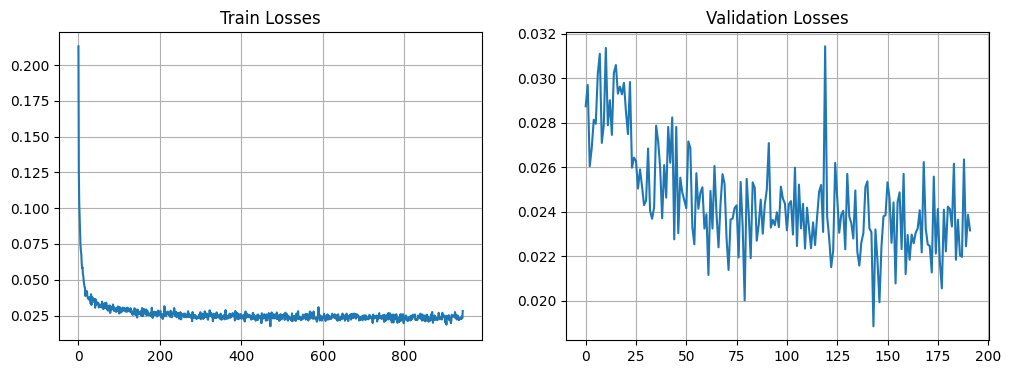

In [23]:
plt.subplots(1,2,figsize=(12,4))

plt.subplot(1,2,1)
plt.title("Train Losses")
plt.plot(range(len(train_loss)),train_loss);
plt.grid()

plt.subplot(1,2,2)
plt.title("Validation Losses")
plt.plot(range(len(val_loss)),val_loss);
plt.grid()

Test de lectura de fichero de entrenamiento

In [ ]:
# model.load_state_dict(torch.load("Second_train.pth", weights_only=True))
# model.eval()

## Generación de Imágenes
2 Opciones:
* Usar pipeline ya montado
* Crear nuestro propio modelo de generación de imágenes

In [24]:
# Pipeline
pipeline = diffusers.DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=8).images

tensor_imgs = [transforms.functional.to_tensor(x) for x in ims]

show_images_list(tensor_imgs)

  0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: LinealScheduler.step() got an unexpected keyword argument 'generator'

0


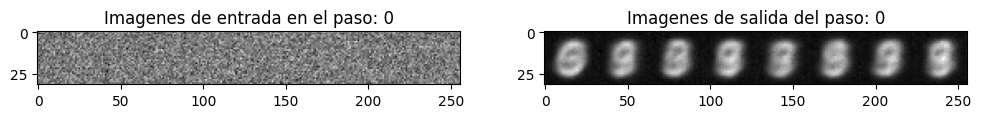

100


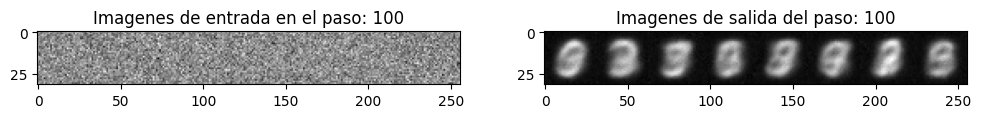

200


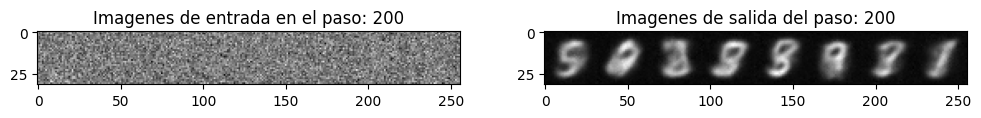

300


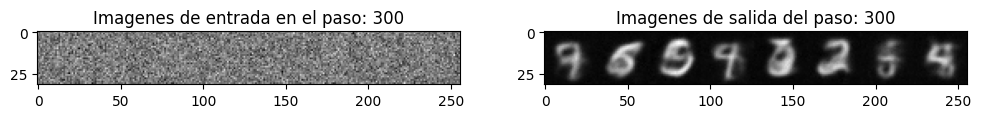

400


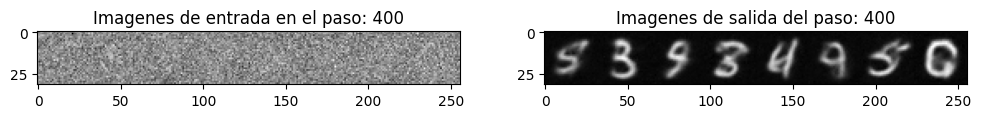

500


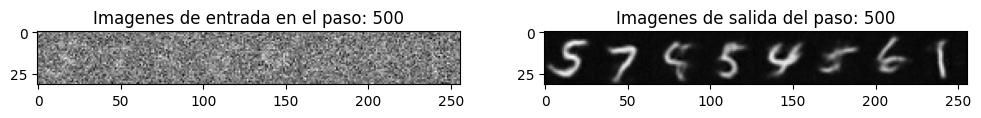

600


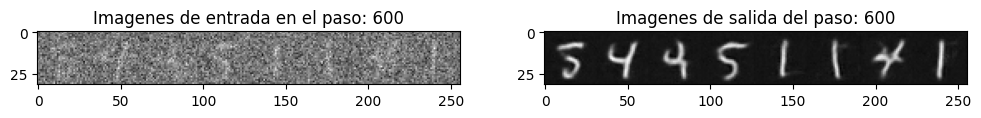

700


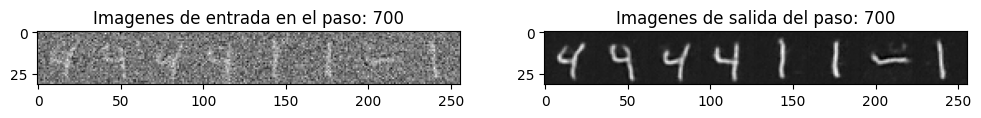

800


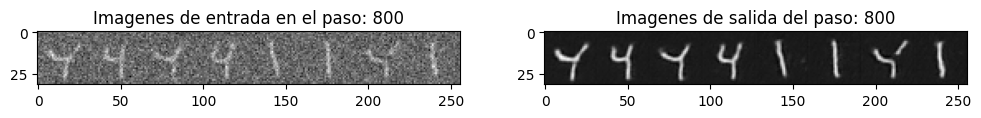

900


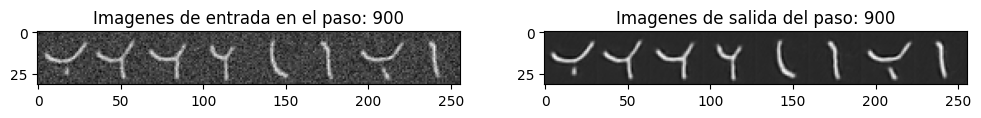

999


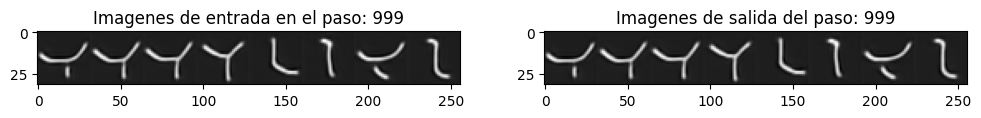

In [25]:
image = torch.randn_like(noised_x).cuda()
# Bucle de generación
for i, t in enumerate(scheduler.timesteps):

    with torch.inference_mode():                        # Iteramos una vez. No estamos entrenando, por lo que usamos el modo inferencia.
        img_pred = model(image,t).sample

    # Calculamos la actualización de nuestras muestras aleatorias
    new_noise = torch.randn_like(img_pred)
    scheduler_output = scheduler.step(new_noise, t, img_pred)

    # volvemos a utilizar los datos como generados como entrada de la red
    image = scheduler_output

    # Mostramos los resultados.
    if (i%100 == 0) or (i == len(scheduler.timesteps)-1):
        
        img_list = [x for x in scheduler_output]
        generation_list = [x for x in img_pred]

        full_img = torch.cat(img_list,dim=2)
        full_generation = torch.cat(generation_list, dim=2)

        plt.subplots(1,2,figsize=(12,4))
        print(i)
        
        plt.subplot(1,2,1)
        plt.title("Imagenes de entrada en el paso: "+str(i))
        show_images(full_img.cpu());

        plt.subplot(1,2,2)
        plt.title("Imagenes de salida del paso: "+str(i))
        show_images(full_generation.cpu());

        plt.pause(0.1)

Llegamos a un resultado bastante bueno con pocas iteraciones. De hecho, al continuar, solamente estropea algunos de los números.

Ocurre exactamente lo mismo para este caso. Al llegar a los pasos 700~800, el planificador añade tanto ruido que el modelo empieza a inventar resultados, provocando la generación corrupta de imágenes.